<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Regularization/L2_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Logistic Regression with L2 Regularization

Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LAMBDA = 2

Preping dataset

In [3]:
data = np.genfromtxt('https://raw.githubusercontent.com/rasbt/stat453-deep-learning-ss20/master/L07-logistic/code/data/toydata.txt',
                     delimiter='\t')
x = data[:, :2].astype(np.float32)
y = data[:, 2].astype(np.int64)

In [18]:
np.random.seed(123)
idx = np.arange(x.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train, X_test = (X_train - mu) / sigma, (X_test - mu) / sigma 

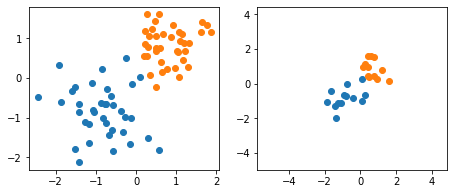

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3))
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
plt.xlim([x[:, 0].min()-0.5, x[:, 0].max()+0.5])
plt.ylim([x[:, 1].min()-0.5, x[:, 1].max()+0.5])
plt.show()

## L2 Regularized Logistic Regression via ```weight_decay```

In [28]:
def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((1-cond) * x_2)

class LogisticRegression(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)

        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        ## We don't need random small weights since it is logistic regression 

    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas 

model = LogisticRegression(num_features=2)

## Applying L2 regularization 
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.1,
                            weight_decay=LAMBDA)

def comp_accuracy(label_var, pred_probas):
    pred_labels = custom_where((pred_probas > 0.5).float(), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc

num_epochs = 30

X_train_tensor = torch.tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float, device=device).view(-1, 1)

for epoch in range(num_epochs):

    #compute outputs 
    out = model(X_train_tensor)

    # Compute gradients 
    cost = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')

    optimizer.zero_grad()
    cost.backward()

    ## updating weights
    optimizer.step()

    ## Loggin 
    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print(f"Epoch: {epoch+1:03d}", end="")
    print(f"  |  Train Acc: {acc:.3f}", end="")
    print(f"  |  Cost: {F.binary_cross_entropy(pred_probas, y_train_tensor):.3f}")

print("\nModel Parameters:")
print(f"    Weights: {model.linear.weight}")
print(f"    Bias: {model.linear.bias}")

Epoch: 001  |  Train Acc: 0.973  |  Cost: 0.055
Epoch: 002  |  Train Acc: 0.973  |  Cost: 0.065
Epoch: 003  |  Train Acc: 0.973  |  Cost: 0.080
Epoch: 004  |  Train Acc: 0.973  |  Cost: 0.094
Epoch: 005  |  Train Acc: 0.973  |  Cost: 0.104
Epoch: 006  |  Train Acc: 0.973  |  Cost: 0.108
Epoch: 007  |  Train Acc: 0.973  |  Cost: 0.110
Epoch: 008  |  Train Acc: 0.973  |  Cost: 0.111
Epoch: 009  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 010  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 011  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 012  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 013  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 014  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 015  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 016  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 017  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 018  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 019  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 020  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 021  |  Train Acc: 0.973  |  Cost

In [32]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float, device=device)

pred_probas = model(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print(f"\nTest set accuracy: {test_acc*100:.2f}%")


Test set accuracy: 96.00%


## L2 Regularization Logistic Regression via Manual Regularization 

In [34]:
model = LogisticRegression(num_features=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(num_epochs):

    ## compute outputs 
    out = model(X_train_tensor)

    ## comute gradients 
    ## applying L2 regularization (weight decay)
    cost = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')
    cost = cost + 0.5 * LAMBDA * torch.mm(model.linear.weight,
                                    model.linear.weight.t())
    
    # pytorch regularizes the bias as well so if we want to replicate auto SGD's 
    # output we need to regularize the bias as well 
    cost += 0.5 * LAMBDA * (model.linear.bias**2)

    optimizer.zero_grad()
    cost.backward()

    # update the weights 
    optimizer.step()

    #Logging 
    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print(f"Epoch: {epoch+1:03d}", end="")
    print(f"  |  Train Acc: {acc:.3f}", end="")
    print(f"  |  Cost: {F.binary_cross_entropy(pred_probas, y_train_tensor):.3f}")

print("\nModel Parameters:")
print(f"    Weights: {model.linear.weight}")
print(f"    Bias: {model.linear.bias}")

Epoch: 001  |  Train Acc: 0.973  |  Cost: 0.055
Epoch: 002  |  Train Acc: 0.973  |  Cost: 0.065
Epoch: 003  |  Train Acc: 0.973  |  Cost: 0.080
Epoch: 004  |  Train Acc: 0.973  |  Cost: 0.094
Epoch: 005  |  Train Acc: 0.973  |  Cost: 0.104
Epoch: 006  |  Train Acc: 0.973  |  Cost: 0.108
Epoch: 007  |  Train Acc: 0.973  |  Cost: 0.110
Epoch: 008  |  Train Acc: 0.973  |  Cost: 0.111
Epoch: 009  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 010  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 011  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 012  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 013  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 014  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 015  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 016  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 017  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 018  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 019  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 020  |  Train Acc: 0.973  |  Cost: 0.112
Epoch: 021  |  Train Acc: 0.973  |  Cost

In [35]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float, device=device)

pred_probas = model(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print(f"\nTest set accuracy: {test_acc*100:.2f}%")


Test set accuracy: 96.00%
